## Representation visualization (Stable Diffusion v1.4)
This notebook reproduces **Figure 6**:

1. Load two prompt sets (Mem vs Gen) and generate images (DDIM).
2. Extract pooled UNet activations at a chosen layer.
3. Compare representation structure and separation.


In [2]:
import os
from pathlib import Path

import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from sklearn.metrics import roc_auc_score

from io_utils import read_jsonlines
from generate_utils import load_sd_pipe, generate_and_store
from rep_extraction_utils import ExtractConfig, stats_to_jsonl, extract_one, extract_layer_values

import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch


# --- shared figure config (same pixel size across all saved figs) ---
FIGSIZE = (10.8, 5.2)   # inches
SAVE_DPI = 300

PLOT_RC = {
    "axes.titlesize": 28,
    "axes.labelsize": 24,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 24,
}


# -------------------------
# Minimal helpers
# -------------------------
def set_random_seed(seed: int):
    seed = int(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def get_dataset(dataset_spec: str):
    """Load a prompt dataset.

    Supported:
      - Local *.jsonl: list of dicts; we auto-detect the prompt key.
      - HuggingFace dataset name: uses `datasets.load_dataset(name, split='train')`.
    Returns: (dataset_like, prompt_key)
    """
    dataset_spec = str(dataset_spec)
    candidate_namings = ["prompt", "caption", "text", "Prompt", "Caption"] # common prompt naming
    # local jsonl
    if dataset_spec.endswith(".jsonl") and os.path.exists(dataset_spec):
        rows = list(read_jsonlines(dataset_spec))
        if len(rows) == 0:
            raise ValueError(f"Empty jsonl: {dataset_spec}")
        # common prompt keys
        for k in candidate_namings:
            if k in rows[0]:
                return rows, k
        raise KeyError(f"Cannot find a prompt field in first row of {dataset_spec}. "
                       f"Expected one of: prompt/caption/text.")
    
    # HF datasets
    from datasets import load_dataset
    ds = load_dataset(dataset_spec, split="train")
    for k in candidate_namings:
        if k in ds.column_names:
            return ds, k
    raise KeyError(f"Cannot find a prompt column in HF dataset {dataset_spec}. "
                   f"Available columns: {ds.column_names}")


/home/zzekai/.conda/envs/playground/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1) Load prompt datasets (Mem vs Gen)
**Allowed**:
- Local `*.jsonl` (one dict per line; must contain `prompt` or `caption` or `text`)
- Hugging Face dataset name (loaded with `datasets.load_dataset`)

We convert each dataset to a small `jsonl` manifest for reproducibility.


In [3]:
# -------------------------
# Tunables
# -------------------------
DATASET_MEM = "sdv1_500_memorized.jsonl"
DATASET_GEN = "Gustavosta/Stable-Diffusion-Prompts"

N_MEM = 100 #  reduced for a faster demo, use 500 for results in paper
N_GEN = 100
SEED = 0

# List of hook points (feel free to change).
HOOK_NAMES = (
    "up_blocks.0.resnets.0.nonlinearity",
    "up_blocks.0.resnets.1.nonlinearity",
    "up_blocks.0.resnets.2.nonlinearity",
    "up_blocks.1.resnets.0.nonlinearity",
)

MODEL_ID = "CompVis/stable-diffusion-v1-4"
SAMPLE_DIR = Path("samples")
RUN_MEM = "detection/mem"
RUN_GEN = "detection/gen"

SAMPLE_DIR.mkdir(exist_ok=True)

set_random_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

pipe = load_sd_pipe(MODEL_ID, device=DEVICE)

ds_mem, key_mem = get_dataset(DATASET_MEM)
ds_gen, key_gen = get_dataset(DATASET_GEN)

print("[INFO] mem dataset:", DATASET_MEM, "| key:", key_mem, "| size:", len(ds_mem))
print("[INFO] gen dataset:", DATASET_GEN, "| key:", key_gen, "| size:", len(ds_gen))


Reading JSON lines from sdv1_500_memorized.jsonl: 100%|██████████| 500/500 [00:00<00:00, 359840.77lines/s]


[INFO] mem dataset: sdv1_500_memorized.jsonl | key: caption | size: 500
[INFO] gen dataset: Gustavosta/Stable-Diffusion-Prompts | key: Prompt | size: 73718


## 2) Generate images + write JSONL datasets
Writes:
- `samples/<run_name>/<idx>.png`
- `samples/<run_name>_all.jsonl` (each line: `{url, prompt}`)


[INFO] num mem prompts: 100 | example: The No Limits Business Woman Podcast
[INFO] num gen prompts: 100 | example: realistic car 3 d render sci - fi car and sci - fi robotic factory structure in the coronation of napoleon painting and digital billboard with point cloud in the middle, unreal engine 5, keyshot, octane, artstation trending, ultra high detail, ultra realistic, cinematic, 8 k, 1 6 k, in style of zaha hadid, in style of nanospace michael menzelincev, in style of lee souder, in plastic, dark atmosphere, tilt shift, depth of field,


100%|██████████| 50/50 [00:01<00:00, 25.54it/s]
Writing JSON lines at samples/detection/mem_all.jsonl: 100%|██████████| 100/100 [00:00<00:00, 186000.18it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (101 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['incev , in style of lee souder , in plastic , dark atmosphere , tilt shift , depth of field ,']
100%|██████████| 50/50 [00:01<00:00, 25.34it/s]
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['trending on art station']
100%|██████████| 50/50 [00:01<00:00, 25.53it/s]
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['m , very coherent , triadic color scheme , art by takato yamamoto and james jean']
100%|██████████| 50/50 [00:01<00:00, 25.62it/s

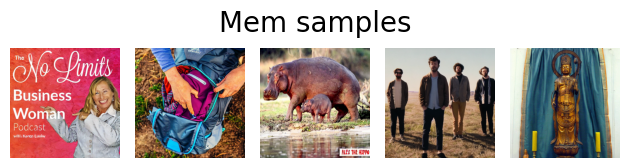

Reading JSON lines from samples/detection/gen_all.jsonl: 100%|██████████| 100/100 [00:00<00:00, 340446.75lines/s]


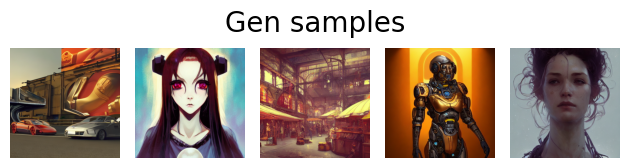

In [4]:
def sample_prompts(ds, key: str, n: int) -> list[str]:
    n = int(min(n, len(ds)))
    return [str(ds[i][key]) for i in range(n)]

mem_prompts = sample_prompts(ds_mem, key_mem, N_MEM)
gen_prompts = sample_prompts(ds_gen, key_gen, N_GEN)

print("[INFO] num mem prompts:", len(mem_prompts), "| example:", mem_prompts[0])
print("[INFO] num gen prompts:", len(gen_prompts), "| example:", gen_prompts[0])

NUM_STEPS = 50
GUIDANCE = 7.5

mem_jsonl = generate_and_store(
    pipe,
    mem_prompts,
    out_root=str(SAMPLE_DIR),
    run_name=RUN_MEM,
    seed=SEED,
    num_inference_steps=NUM_STEPS,
    guidance_scale=GUIDANCE,
)
gen_jsonl = generate_and_store(
    pipe,
    gen_prompts,
    out_root=str(SAMPLE_DIR),
    run_name=RUN_GEN,
    seed=SEED + 10,
    num_inference_steps=NUM_STEPS,
    guidance_scale=GUIDANCE,
)

def _read_png(fp: str):
    return np.asarray(Image.open(fp).convert("RGB"))

def show_grid(jsonl_path: str, title: str, n: int = 8):
    rows = list(read_jsonlines(jsonl_path))[: int(n)]
    if len(rows) == 0:
        print("Empty jsonl:", jsonl_path)
        return
    imgs = [_read_png(r["url"]) for r in rows]

    fig, axes = plt.subplots(1, len(imgs))
    axes = [axes] if len(imgs) == 1 else axes
    for ax, im in zip(axes, imgs):
        ax.imshow(im)
        ax.axis("off")

    fig.suptitle(title, fontsize=20, y=0.65)
    fig.tight_layout()
    plt.show()

show_grid(mem_jsonl, "Mem samples", n=min(5, N_MEM))
show_grid(gen_jsonl, "Gen samples", n=min(5, N_GEN))

## 3) Extract representations + stats


In [5]:
# -------------------------
# 3) Extract pooled representations, then store stats
# -------------------------
check_timestep = 10
target_layer = HOOK_NAMES[2]  # change if you want

mem_stats_jsonl = str(SAMPLE_DIR / f"{RUN_MEM}_stats.jsonl")
gen_stats_jsonl = str(SAMPLE_DIR / f"{RUN_GEN}_stats.jsonl")

mem_stats = stats_to_jsonl(
    ExtractConfig(
        dataset_jsonl=mem_jsonl,
        out_jsonl=mem_stats_jsonl,
        check_timestep=check_timestep,
        hook_names=tuple(HOOK_NAMES),
        pooling="spatial_max",
        use_prompt=False,
        image_size=512,
    ),
    pipe=pipe,
)

gen_stats = stats_to_jsonl(
    ExtractConfig(
        dataset_jsonl=gen_jsonl,
        out_jsonl=gen_stats_jsonl,
        check_timestep=check_timestep,
        hook_names=tuple(HOOK_NAMES),
        pooling="spatial_max",
        use_prompt=False,
        image_size=512,
    ),
    pipe=pipe,
)

mem_std = extract_layer_values(mem_stats, target_layer, key="std")
gen_std = extract_layer_values(gen_stats, target_layer, key="std")

y = np.r_[np.ones_like(mem_std), np.zeros_like(gen_std)]
s = np.r_[mem_std, gen_std]

print("[INFO] stats jsonl:", mem_stats_jsonl, gen_stats_jsonl)
print("[INFO] extracted at", target_layer)


Reading JSON lines from samples/detection/mem_all.jsonl: 100%|██████████| 100/100 [00:00<00:00, 399077.45lines/s]
Extract reps @t=10: 100%|██████████| 100/100 [00:09<00:00, 11.06it/s]
Writing JSON lines at samples/detection/mem_stats.jsonl: 100%|██████████| 100/100 [00:00<00:00, 64847.00it/s]
Reading JSON lines from samples/detection/gen_all.jsonl: 100%|██████████| 100/100 [00:00<00:00, 339344.98lines/s]
Extract reps @t=10: 100%|██████████| 100/100 [00:08<00:00, 11.92it/s]
Writing JSON lines at samples/detection/gen_stats.jsonl: 100%|██████████| 100/100 [00:00<00:00, 63675.48it/s]

[INFO] stats jsonl: samples/detection/mem_stats.jsonl samples/detection/gen_stats.jsonl
[INFO] extracted at up_blocks.0.resnets.2.nonlinearity


## 4) Plots
- **Rep overlay**: one Mem sample vs one Gen sample at `target_layer` and timestep `t`.
- **Std separation**: KDE of pooled activation std across all samples (Mem vs Gen).


Reading JSON lines from samples/detection/mem_all.jsonl: 100%|██████████| 100/100 [00:00<00:00, 421962.17lines/s]
Reading JSON lines from samples/detection/gen_all.jsonl: 100%|██████████| 100/100 [00:00<00:00, 362515.47lines/s]


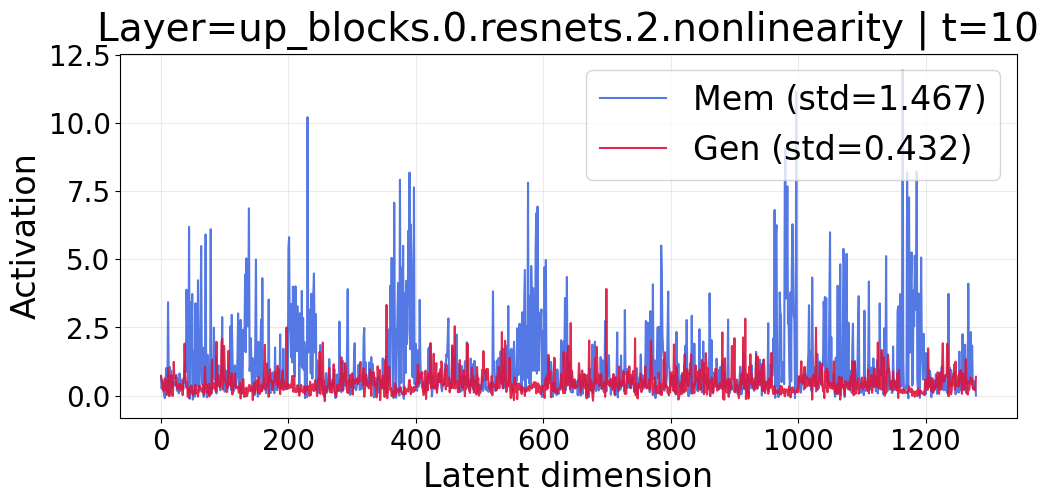

In [ ]:
# -------------------------
# 4) Plot: example reps (Mem vs Gen) at the chosen layer
# -------------------------
FIG_DIR = Path("../Figs")
FIG_DIR.mkdir(exist_ok=True)

# pick the first generated sample from each set
mem_row = list(read_jsonlines(mem_jsonl))[2]
gen_row = list(read_jsonlines(gen_jsonl))[2]

mem_reps, _ = extract_one(
    pipe,
    image_path=mem_row["url"],
    prompt=mem_row.get("prompt", ""),
    check_timestep=check_timestep,
    hook_names=tuple(HOOK_NAMES),
    pooling="spatial_max",
    use_prompt=False,
    image_size=512,
    return_reps=True,
)

gen_reps, _ = extract_one(
    pipe,
    image_path=gen_row["url"],
    prompt=gen_row.get("prompt", ""),
    check_timestep=check_timestep,
    hook_names=tuple(HOOK_NAMES),
    pooling="spatial_max",
    use_prompt=False,
    image_size=512,
    return_reps=True,
)

vis_feature_mem = mem_reps[target_layer]
vis_feature_gen = gen_reps[target_layer]

std_mem = float(vis_feature_mem.std(unbiased=False))
std_gen = float(vis_feature_gen.std(unbiased=False))

plt.rcParams.update(PLOT_RC)
fig, ax = plt.subplots(figsize=FIGSIZE)

ax.plot(vis_feature_mem.numpy(), color="royalblue", alpha=0.90,
        label=f"Mem (std={std_mem:.3f})")
ax.plot(vis_feature_gen.numpy(), color="crimson", alpha=0.90,
        label=f"Gen (std={std_gen:.3f})")

ax.set_title(f"Layer={target_layer} | t={check_timestep}", pad=10)
ax.set_xlabel("Latent dimension")
ax.set_ylabel("Activation")
ax.grid(True, alpha=0.25)
ax.legend(loc="upper right", frameon=True)

fig.subplots_adjust(top=0.88, bottom=0.18, left=0.12, right=0.95)
fig.savefig(FIG_DIR / "laion_reps.png", dpi=SAVE_DPI, bbox_inches="tight")
plt.show()

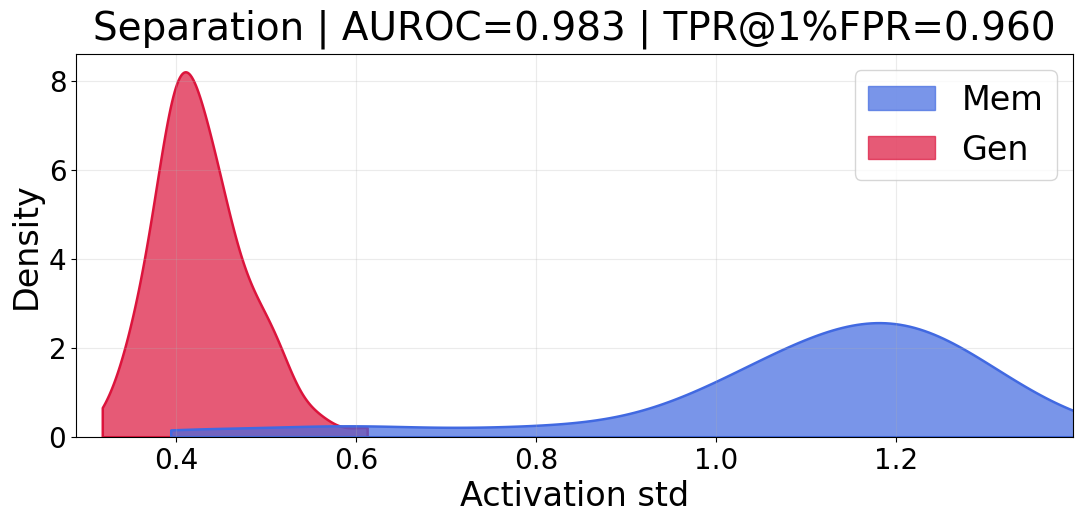

In [8]:
# -------------------------
# 4b) Plot: std separation (KDE)
# -------------------------
def tpr_at_fpr(y_true: np.ndarray, scores: np.ndarray, fpr: float = 0.01) -> float:
    """TPR at a given FPR (higher scores => more positive)."""
    y_true = np.asarray(y_true).astype(bool)
    scores = np.asarray(scores).astype(np.float32)
    neg = scores[~y_true]
    if neg.size == 0:
        return float("nan")
    thr = np.quantile(neg, 1.0 - float(fpr))
    return float((scores[y_true] >= thr).mean())

auroc = roc_auc_score(y, s)
tpr01 = tpr_at_fpr(y, s, fpr=0.01)

merged_df = pd.DataFrame({
    "std": np.concatenate([np.asarray(mem_std), np.asarray(gen_std)]),
    "origin": ["Mem"] * len(mem_std) + ["Gen"] * len(gen_std),
})

order = ["Mem", "Gen"]
palette = {"Mem": "royalblue", "Gen": "crimson"}
fill_alpha = 0.70


plt.rcParams.update(PLOT_RC)
fig, ax = plt.subplots(figsize=FIGSIZE)

ax = sns.kdeplot(
    data=merged_df,
    x="std",
    hue="origin",
    hue_order=order,
    palette=palette,
    fill=True,
    alpha=fill_alpha,
    common_norm=False,
    legend=False,
    linewidth=1.8,
    cut=0,
    ax=ax,
)

lo, hi = np.quantile(merged_df["std"].to_numpy(), [0.01, 0.99])
if np.isfinite(lo) and np.isfinite(hi) and hi > lo:
    pad = 0.06 * (hi - lo)
    ax.set_xlim(lo - pad, hi + pad)

ax.set_title(f"Separation | AUROC={auroc:.3f} | TPR@1%FPR={tpr01:.3f}", pad=10)
ax.set_xlabel("Activation std")
ax.set_ylabel("Density")
ax.grid(True, alpha=0.25)

handles = [
    Patch(facecolor=palette[label], edgecolor=palette[label], alpha=fill_alpha, label=label)
    for label in order
]
ax.legend(handles=handles, loc="upper right", frameon=True, title=None)

fig.tight_layout(pad=0.6)
fig.savefig(FIG_DIR / "laion_separation.png", dpi=SAVE_DPI, bbox_inches='tight')
plt.show()